## Cеминар 3. Регрессия по тексту

В этом задании мы построим модель глубокого обучения, которая предсказывает зарплату на основе резюме/описания вакансии (all credits to [Oleg Vasilev](https://github.com/Omrigan/)).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### О задаче
Для начала скачаем и распакуем данные (датасет вакансий/описаний и зарплат).

Также можно получить данные по ссылке на [Яндекс.Диск](https://yadi.sk/d/vVEOWPFY3NruT7) и со страницы соревнования на [Kaggle](https://www.kaggle.com/c/job-salary-prediction/data) (нужно взять файл Train_rev1.*).

In [ ]:
# Скачиваем zip-архив с датасетом в файл Train_rev1.zip
# В Colab / Linux окружении команда wget обычно доступна по умолчанию
!wget -O Train_rev1.zip https://www.dropbox.com/scl/fi/9fy81b0tzuybb2wx48w14/Train_rev1.zip?rlkey=w3sqhym07l6nn89hwqb01pjmx&st=c10n9jqu&dl=1

# Читаем CSV из zip-архива напрямую (pandas умеет так делать)
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)

# Смотрим размерность датасета: (число строк, число столбцов)
data.shape

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


**Почему берем логарифм зарплаты**

> Если разбирать линейную регрессия с [вероятностной](https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem04-linregr.pdf) точки зрения, то можно получить, что шум должен быть распределён нормально. Поэтому лучше, когда целевая переменная распределена также нормально.

Одна из проблем предсказания зарплаты - распределение таргета странное:

* много людей с обычной зарплатой,
* и небольшое число людей с очень высокой зарплатой.

Такое распределение **имеет тяжёлый правый хвост** (fat-tailed), и это неудобно для оптимизации MSE: редкие очень большие значения могут сильно влиять на ошибку и градиенты.

Есть несколько способов с этим бороться:

* менять функцию потерь,
* предсказывать **логарифм** таргета вместо исходного,
* или даже заменять таргет на его **перцентили** по обучающей выборке.

Здесь мы будем использовать логарифм.

Подробнее: [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

(array([  447.,   267.,   521.,   617.,  5549., 13073., 19631., 22836.,
        33116., 35581., 36991., 28050., 16408., 17527.,  7096.,  5505.,
         1309.,   135.,    64.,    45.]),
 array([ 8.51739311,  8.70182705,  8.88626194,  9.07069588,  9.25512981,
         9.43956375,  9.62399864,  9.80843258,  9.99286652, 10.17730141,
        10.36173534, 10.54616928, 10.73060417, 10.91503811, 11.09947205,
        11.28390694, 11.46834087, 11.65277481, 11.83720875, 12.02164364,
        12.20607758]),
 <BarContainer object of 20 artists>)

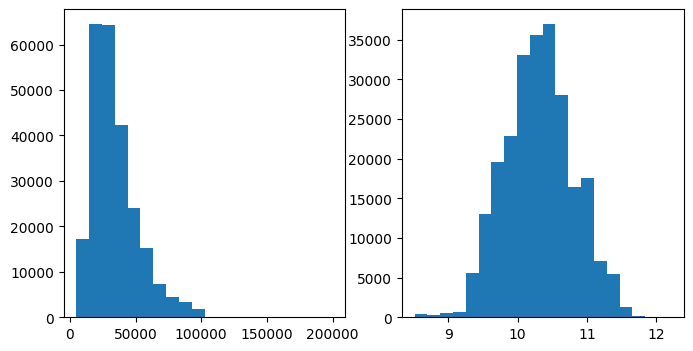

In [4]:
# Создаём новый таргет: log1p(SalaryNormalized)
# log1p(x) = log(1 + x), он устойчивее для нулей/малых значений
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])

plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)

Наша задача - предсказать одно число: **Log1pSalary**.

Для этого будем использовать следующие признаки:

* **Текстовые признаки** (free text): `Title` и `FullDescription`
* **Категориальные признаки** (categorical):
  `Category`, `Company`, `LocationNormalized`, `ContractType`, `ContractTime`

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

# В категориальных признаках есть пропуски: заменим их строкой "NaN"
# (важно именно строкой, потому что дальше будем делать one-hot)
data[categorical_columns] = data[categorical_columns].fillna('NaN')

# Посмотрим несколько случайных строк
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
130952,70174888,Relief Courtesy Vehicle Driver/Car Park Attend...,About the role A great day out here at Petwort...,Petworth,Petworth,part_time,NaN,National Trust,Customer Services Jobs,7.00 - 7.00 per hour,13440,Jobcentre Plus,9.506065
191044,71748937,Customer Services Manager,Company Profile Quickdox is a specialist home ...,"Blackburn, Lancashire",Blackburn,NaN,permanent,P2P Group,Accounting & Finance Jobs,22000 - 25000/annum Excellent bens,23500,cv-library.co.uk,10.064798
128714,70101235,Infrastructure Support Specialist,"My client, Europe's leading specialist in the ...",Staines Middlesex England,UK,NaN,NaN,IQ ESM,Customer Services Jobs,350 per day,84000,gojobsearch.co.uk,11.338584


### Предобработка текстовых данных (Preprocessing text data)


Как и в прошлую неделю, применение NLP начинается с **токенизации**:
мы разбиваем сырой текст на последовательности токенов (слова, пунктуация и т.д.).

**Задание:** привести текст к нижнему регистру и токенизировать все тексты в колонках `Title` и `FullDescription`.
Результат будем хранить как **строку токенов, разделённых пробелом** - так быстрее работать дальше.

Можно использовать токенизаторы NLTK. Ассерты рассчитаны на `WordPunctTokenizer`, небольшие отклонения допустимы.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
def tokenize_row(row: str) -> str:
    row = str(row)
    return ' '.join(tokenizer.tokenize(row)).lower()

In [8]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
for col in text_columns:
    data[col] = data[col].apply(tokenize_row)

Теперь можно считать, что каждый текст - это строка токенов, разделённых пробелами.



In [9]:
print("Tokenized:")
print(data["FullDescription"][2::100000])

# Проверочные утверждения (на конкретных индексах)
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Не все слова одинаково полезны:

* некоторые - опечатки,
* некоторые - суперредкие слова, встречающиеся пару раз.

Посчитаем, сколько раз встречается каждое слово в датасете, чтобы построить белый список известных слов.

In [10]:
from collections import Counter

# Счётчик частот токенов
token_counts = Counter()

# Небольшая строка в оригинале (не несёт особого смысла, но оставляем как есть)
token_counts += Counter(data['Title'].values[1].split())

In [11]:
from collections import Counter

# Переинициализируем счётчик (как в оригинале)
token_counts = Counter()

# Считаем, сколько раз каждый токен встречается суммарно в Title и FullDescription
for title in data['Title'].values:
    for token in title.split():
        token_counts[token] += 1

for desc in data['FullDescription'].values:
    for token in desc.split():
        token_counts[token] += 1

print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)


In [12]:
# Проверочные утверждения по статистике токенов
assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Correct!


Text(0.5, 0, 'Word counts')

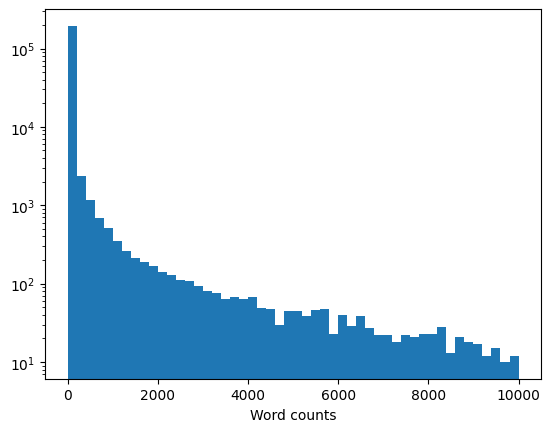

In [13]:
# Посмотрим распределение частот
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts")

Получаем список всех токенов, которые встречаются минимум 10 раз.

In [14]:
min_count = 10

# Берём токены из token_counts, у которых частота >= min_count
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Добавим специальные токены:
# UNK — неизвестное слово (out-of-vocabulary)
# PAD — паддинг (для выравнивания длины последовательностей)
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

print("Vocabulary size:", len(tokens))

# Проверки формата и содержимого
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Построим обратный индекс токенов - словарь `token_to_id`, который отображает токен (строку) в его индекс в `tokens` (целое число).

In [15]:
tokens.index('PAD')

1

```
# Cписок токенов (словарь)
tokens = ['apple', 'cat', 'I', 'like', 'PAD', 'the']
# Индексы: 0        1      2    3       4      5
```

In [16]:
# Строим словарь токен -> индекс
token_to_id ={token: ind for ind, token in enumerate(tokens)}

In [17]:
# Проверки на корректность и взаимно-однозначность
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


Теперь используем построенный словарь, чтобы переводить строки текста в матрицы индексов, которые можно подавать в нейросеть.

In [18]:
# Берём все заголовки как "последовательности"
sequences = data['Title']

In [19]:
sequences[sequences.apply(len) == 202]

,Title
26468,"oracle apps financials developer ( sql , pl / ..."


In [20]:
# Индексы специальных токенов
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """
    Переводим список токенов в матрицу индексов с паддингом.

    sequences: list[str] или list[list[str]]
      - если это строки, считаем, что токены разделены пробелом

    max_len: максимальная длина последовательности
      - если None: берём максимум по данным
      - если задано: ограничиваем длину

    Возвращаем:
      matrix: np.ndarray shape [N, max_len] заполненная PAD_IX
    """
    if isinstance(sequences[0], str):
        # Если пришли строки, превращаем в списки токенов
        sequences = list(map(str.split, sequences))

    # max_len = min(макс длина по данным, заданный max_len)
    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    # Создаём матрицу и заполняем паддингом
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))

    for i, seq in enumerate(sequences):
        # Берём первые max_len токенов, переводим в индексы (неизвестные -> UNK_IX)
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        # Записываем индексы в матрицу
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [21]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Теперь закодируем категориальные признаки.

Как обычно, для простоты используем **one-hot encoding**.

(Если хочется усложнить: можно попробовать tf-idf по категориям, частотные энкодинги, target encoding и т.п.)

In [22]:
# Превращаем каждую строку категориальных признаков в словарь "feature: value"
data[categorical_columns].apply(dict, axis=1)

,0
0,"{'Category': 'Engineering Jobs', 'Company': 'G..."
1,"{'Category': 'Engineering Jobs', 'Company': 'G..."
2,"{'Category': 'Engineering Jobs', 'Company': 'G..."
3,"{'Category': 'Engineering Jobs', 'Company': 'G..."
4,"{'Category': 'Engineering Jobs', 'Company': 'G..."
...,...
244763,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244764,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244765,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244766,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."


In [23]:
from sklearn.feature_extraction import DictVectorizer

# Чтобы уменьшить объём памяти, оставим только топ-1000 самых частых компаний.
# Остальные компании заменим на "Other".
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)

data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

# DictVectorizer преобразует список словарей в матрицу one-hot / числовых признаков
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### Часть с глубоким обучением

Теперь, когда мы научились токенизировать и кодировать данные, спроектируем эксперимент.

Как и раньше, мы не будем углубляться в сложную схему валидации: сделаем простое разделение на train/val.

**Строго говоря**, здесь есть небольшой грех: мы использовали весь датасет для токенизации и построения словаря.
При строгом подходе это нужно делать только на train, а затем применять к val/test. Можно попробовать сделать правильно и измерить, насколько это влияет.

In [24]:
from sklearn.model_selection import train_test_split

# Делим на обучающую и валидационную выборки
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

# Сбрасываем индексы (чтобы потом было удобнее обращаться по позициям)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Выбираем устройство: GPU если доступно, иначе CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
def to_tensors(batch, device):
    """
    Преобразуем подготовленный batch (словарь numpy-массивов) в batch из torch.Tensor.
    Важно: текстовые матрицы должны быть int64 (индексы токенов).
    Остальные признаки — float32 (или как получилось).
    """
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Готовим один батч для модели.

    Возвращаем словарь:
      - "Title": int64 [batch, title_len]
      - "FullDescription": int64 [batch, desc_len]
      - "Categorical": float32 [batch, n_cat]
      - TARGET_COLUMN: float32 [batch] (если есть в данных)

    Параметр word_dropout:
      - с вероятностью word_dropout заменяем токены в FullDescription на UNK
      - это напоминает regularization / data augmentation для текста
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)


def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX):
    """
    Применяем word dropout к матрице индексов:
    - генерируем маску "заменить/не заменить"
    - паддинги не трогаем
    - заменяем выбранные токены на UNK
    """
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [27]:
[tokens[idx] for idx in [27645, 29893, 33674,     1,     1,     1,     1]]

['senior', 'support', 'worker', 'PAD', 'PAD', 'PAD', 'PAD']

#### Архитектура

Базовая модель состоит из трёх веток:

* энкодер заголовка (Title encoder)
* энкодер описания (Description encoder)
* энкодер категориальных признаков (Categorical features encoder)

После этого мы объединяем (конкатенируем) представления и предсказываем зарплату.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

Что выбираем:

* #filters (m) на каждый размер окна (kernel size): это сколько разных шаблонов мы хотим ловить.
* #conv layers: насколько глубоко строим признаки.
* kernel sizes: какие n-граммы ловим (2/3/4/5 и т.д.).
* pooling: чаще global max pooling.

Практика по умолчанию:

* 1 conv-слой.
* kernel sizes: `[3,4,5]` (или `[2,3,4]`).
* filters per size: 100–300 (типичный старт: 100).
* global max pooling + dropout 0.2–0.5 + linear.

Интуиция выбора:

* Больше фильтров → больше детекторов паттернов → выше ёмкость модели, но больше риск overfit и медленнее.
* Больше слоёв → паттерны могут становиться более композиционными, но для текста часто не нужно много слоёв, особенно если вход уже эмбеддинги.

Когда увеличивать:

* много данных и сложные классы → можно поднять filters (например, 128→256→512 суммарно по всем окнам) или добавить 2-й conv-слой.
* качество упёрлось, а train и val близки → увеличивать ёмкость имеет смысл.

Когда уменьшать:

* train высокий, val проседает → уменьшать filters, добавлять dropout, L2, сильнее регуляризировать.
* мало данных → 1 слой и меньше фильтров (например, 50–100 на размер окна).

In [28]:
class TextEncoder(nn.Module):
    """
    Энкодер текста на свёртках:
      - Embedding -> Conv1d -> BN -> Dropout (несколько слоёв)
      - затем pooling (max / softmax-усиленный)
      - затем Linear для приведения к hid_size
    """
    def __init__(self, embeddings, hid_size, window, dropout_prob=0.2, pooling='mot'):
        super().__init__()
        self.emb = embeddings
        self.emb_size = self.emb.weight.shape[1]  # размерность эмбеддингов
        self.pooling_type = pooling

        # Два свёрточных слоя
        self.conv1 = nn.Conv1d(self.emb_size, hid_size, window)
        self.conv2 = nn.Conv1d(self.emb_size, hid_size, window)

        # BatchNorm для стабилизации обучения
        self.bn1 = nn.BatchNorm1d(hid_size)
        self.bn2 = nn.BatchNorm1d(hid_size)

        # Dropout как регуляризация
        self.dropout = nn.Dropout(p=dropout_prob)

        # После конкатенации двух свёрток (2*hid_size) приводим обратно в hid_size
        self.fc = nn.Linear(in_features=2*hid_size, out_features=hid_size)

    def forward(self, text_indices):
        """
        text_indices: int64 tensor [batch, seq_len] — индексы токенов
        """
        # emb: [B, L, E] -> transpose -> [B, E, L]
        embs = self.emb(text_indices).transpose(2, 1)

        # Conv1d выдаёт [B, hid_size, L'] (L' = L - window + 1, если padding=0)
        conv_outs1 = self.dropout(self.bn1(self.conv1(embs)))
        conv_outs2 = self.dropout(self.bn2(self.conv2(embs)))

        # Склеиваем по каналам: [B, 2*hid_size, L']
        conv_outs = torch.cat((conv_outs1, conv_outs2), dim=1)

        # Pooling по времени (по последней оси)
        if self.pooling_type == 'mot':
            # Max-over-time pooling: берём максимум по всем позициям
            conv_max_pool = torch.max(conv_outs, axis=-1).values
        elif self.pooling_type == 'softmax':
            # Вариант: softmax по каналам, затем взвешиваем значения и max-pool
            conv_outs_softmax = F.softmax(conv_outs, dim=1) * conv_outs
            conv_max_pool = torch.max(conv_outs_softmax, axis=-1).values
        else:
            raise ValueError(f"Unknown pooling type: {self.pooling_type}")

        # Приводим к hid_size
        return self.fc(conv_max_pool)

In [ ]:
!pip install gensim

In [30]:
# Загружаем предобученные эмбеддинги (GloVe Twitter 100d) через gensim

import gensim.downloader as api
gensim_model = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [31]:
def torch_emb_from_gensim(gensim_model, tokens):
    """
    Строим матрицу эмбеддингов под наш словарь tokens.

    Для каждого токена:
      - если он есть в gensim_model, берём его вектор
      - иначе инициализируем случайно (нормальное распределение)
    """
    n_tokens = len(tokens)
    embedding_dim = gensim_model.vector_size

    embedding_matrix = np.zeros((n_tokens, embedding_dim))

    for i, token in enumerate(tokens):
        if token in gensim_model:
            embedding_matrix[i] = gensim_model[token]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

    # Важно: кладём сразу на device
    return torch.tensor(embedding_matrix, dtype=torch.float, device=device)

In [32]:
class SalaryPredictorGensim(nn.Module):
    """
    Полная модель:
      - Embedding слой (инициализирован предобученными эмбеддингами)
      - 2 текстовых энкодера (Title и FullDescription)
      - 1 энкодер категориальных признаков (Linear + BN + Dropout)
      - финальная линейная голова на 1 число (регрессия)
    """
    def __init__(self, embeddings, n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, dropout_prob=0.2):
        super().__init__()
        self.window = 3
        self.hid_size = hid_size

        # Embedding-таблица из предобученных весов
        # freeze=False => эмбеддинги будут дообучаться
        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)

        # Текстовые энкодеры
        self.title_encoder = TextEncoder(self.emb, self.hid_size, self.window, pooling='softmax')
        self.descr_encoder = TextEncoder(self.emb, self.hid_size, self.window, pooling='softmax')

        # BatchNorm и Dropout для выходов текстовых веток
        self.bn_title = nn.BatchNorm1d(self.hid_size)
        self.bn_descr = nn.BatchNorm1d(self.hid_size)
        self.dropout_text = nn.Dropout(p=dropout_prob)

        # Ветка категориальных признаков
        self.fc1 = nn.Linear(n_cat_features, self.hid_size)
        self.bn1 = nn.BatchNorm1d(self.hid_size)  # BN для категориальных
        self.dropout = nn.Dropout(p=dropout_prob)

        # Финальный слой: (title + descr + cat) => 1 число
        self.fc2 = nn.Linear(self.hid_size * 3, 1)

    def forward(self, batch):
        """
        batch — словарь тензоров, который возвращает make_batch.
        """
        # Прогоняем батч через текстовые энкодеры
        title_emb_out = F.relu(self.title_encoder(batch['Title']))
        descr_emb_out = F.relu(self.title_encoder(batch['FullDescription']))

        # BatchNorm для стабилизации
        title_emb_out = self.bn_title(title_emb_out)
        descr_emb_out = self.bn_descr(descr_emb_out)

        # Dropout для регуляризации
        title_emb_out = self.dropout_text(title_emb_out)
        descr_emb_out = self.dropout_text(descr_emb_out)

        # Категориальные признаки: Linear -> ReLU -> BN -> Dropout
        categorical_emb_out = F.relu(self.fc1(batch['Categorical']))
        categorical_emb_out = self.bn1(categorical_emb_out)
        categorical_emb_out = self.dropout(categorical_emb_out)

        # Конкатенация трёх веток
        concat_emb_out = torch.cat((title_emb_out, descr_emb_out, categorical_emb_out), dim=-1)

        # Возвращаем скаляр на объект; squeeze убирает лишнюю размерность
        return self.fc2(concat_emb_out).squeeze()

In [33]:
# Собираем матрицу эмбеддингов под наш словарь tokens
embs_gensim = torch_emb_from_gensim(gensim_model, tokens)

# Создаём модель
model = SalaryPredictorGensim(embs_gensim).to(device)

# Создаём тестовый батч из первых 100 строк train
batch = make_batch(data_train[:100], device=device)

# В регрессии используем MSELoss
criterion = nn.MSELoss()

# Делаем "прогон" для sanity-check
dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])

# Проверки размерностей и адекватности вывода
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Обучение и оценка

Как обычно, мы будем кормить модель случайными мини-батчами.

Во время обучения мы хотим отслеживать не только loss, вычисляемый в лог-пространстве, но и ошибку в реальных значениях (MAE/MSE по `Log1pSalary` в данном коде).

In [34]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """
    Генератор мини-батчей:
      - перемешиваем индексы
      - отдаём батчи размера batch_size
      - если cycle=True, то после конца данных начинаем заново (бесконечный генератор)
    """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle:
            break

### Обучение модели

Мы обучаем модель в мини-батчевом режиме. Интересный момент: обучение идёт по потоку батчей из `iterate_minibatches`.

In [35]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 10

In [36]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    """
    Считаем метрики на датасете:
      - MSE (mean squared error)
      - MAE (mean absolute error)
    """
    squared_error = 0.0
    abs_error = 0.0
    num_samples = 0.0

    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)

    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples

    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)

    return mse, mae

In [37]:
# Переинициализируем модель и обучаем "по-настоящему"
embs_gensim = torch_emb_from_gensim(gensim_model, tokens)
model = SalaryPredictorGensim(embs_gensim).to(device)

# MSELoss с reduction='sum' (будем суммировать по объектам)
criterion = nn.MSELoss(reduction='sum')

# SGD оптимизатор (как в оригинале)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()

    # enumerate(...) даёт i и batch; tqdm показывает прогресс
    for i, batch in tqdm(
        enumerate(iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
        total=len(data_train) // BATCH_SIZE
    ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Оценка на валидации
    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.18432
Mean absolute error: 0.33196
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.18317
Mean absolute error: 0.33592
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12154
Mean absolute error: 0.26674
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12658
Mean absolute error: 0.27494
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12098
Mean absolute error: 0.26751
epoch: 5


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.10997
Mean absolute error: 0.25402
epoch: 6


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12112
Mean absolute error: 0.26675
epoch: 7


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11859
Mean absolute error: 0.26456
epoch: 8


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11684
Mean absolute error: 0.26209
epoch: 9


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12527
Mean absolute error: 0.27281


###  Оъяснение предсказаний

Полезно понимать, как модель принимает решения, прежде чем применять её в проде.
Для линейных моделей это просто: можно посмотреть веса слов.
Но для нейросетей всё сложнее: зависимость нелинейная.

Тем не менее, есть способы заглянуть внутрь:

* смотреть, как модель реагирует на возмущения входа,
* искать входы, которые максимизируют/минимизируют активации нейронов (см. [on distill.pub](https://distill.pub/2018/building-blocks/)),
* строить локальные линейные аппроксимации: LIME [article](https://arxiv.org/abs/1602.04938) и [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters).

Сегодня попробуем самый простой метод: удаление/маскирование по одному токену и просмотр изменения предсказания.

In [38]:
def explain(model, sample, col_name='Title'):
    """
    Оцениваем вклад каждого слова: по очереди заменяем слово на UNK и смотрим,
    как меняется предсказание.

    Возвращаем список (токен, разница).
    """
    # sample обычно — строка data.loc[i], приводим к словарю, чтобы удобно копировать
    sample = dict(sample)

    # Переводим токены в "нормальные" токены из нашего словаря:
    # token_to_id.get(tok, 0) -> индекс токена (если нет, 0)
    # tokens[...] -> обратно токен (строка)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]

    # Создаём DataFrame, где:
    # - первые len(tokens) строк: “выкинули” один токен
    # - последняя строка: baseline (без выкидывания)
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    # По очереди заменяем i-ый токен на UNK
    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(
            UNK if i == drop_i else tok for i, tok in enumerate(sample_col_tokens)
        )

    # Получаем предсказания на всех вариантах: drop-one и baseline
    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()

    # Разница: baseline - pred_with_drop
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)

    return list(zip(sample_col_tokens, diffs))

In [39]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    """
    Рисуем токены с подсветкой: красный/синий по величине веса.
    cmap=bwr: blue-white-red
    """
    def get_color_hex(weight):
        # Превращаем weight в значение от 0 до 1 через сигмоиду, чтобы были мягкие цвета
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]

    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html

In [40]:
# Пример 1: объяснение для Title
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')

sales specialist iv access and infusion

'<p style="font-size:20px;"><span style="background-color: #FEFEFF">sales</span> <span style="background-color: #F8F8FF">specialist</span> <span style="background-color: #ECECFF">iv</span> <span style="background-color: #FFFAFA">access</span> <span style="background-color: #FFFEFE">and</span> <span style="background-color: #FFFCFC">infusion</span></p>'

In [41]:
# Пример 1: объяснение для FullDescription
tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights])

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

'<p style="font-size:14px;"><span style="background-color: #FFF8F8">sales</span> <span style="background-color: #FFFAFA">representative</span> <span style="background-color: #FFFCFC">medical</span> <span style="background-color: #FEFEFF">sales</span> <span style="background-color: #FFFCFC">iv</span> <span style="background-color: #FFFAFA">access</span> <span style="background-color: #FFFEFE">and</span> <span style="background-color: #FFFEFE">infusion</span> <span style="background-color: #FFFCFC">an</span> <span style="background-color: #FEFEFF">opportunity</span> <span style="background-color: #FFFAFA">to</span> <span style="background-color: #FFF6F6">work</span> <span style="background-color: #FFF8F8">for</span> <span style="background-color: #F2F2FF">the</span> <span style="background-color: #F2F2FF">industry</span> <span style="background-color: #F3F3FF">leading</span> <span style="background-color: #FEFEFF">manufacturer</span> <span style="background-color: #FFFEFE">of</span> <spa

In [42]:
# Пример 2: другой индекс
i = 1207
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')

rgn deputy manager northumberland

'<p style="font-size:20px;"><span style="background-color: #F3F3FF">rgn</span> <span style="background-color: #FFF8F8">deputy</span> <span style="background-color: #D8D8FF">manager</span> <span style="background-color: #FFF6F6">northumberland</span></p>'

In [43]:
tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights])

rgn qualified deputy manager northumberland **** per hour in touch recruitment are working on behalf of wellregarded nursing home group to recruit an experienced rgn deputy home manager for their medium sized nursing service in the stocksfield area of northumberland . the role will involve working alongside an experienced home manager to run and manage the service successfully . as deputy manager you will take an active clinical lead , overseeing care being delivered within the service whilst maintaining high standards at all times . working alongside the home manager you will supervise a multidisciplinary team and deal with all aspects of staff recruitment , disciplinary and appraisals and also play a key part in training and developing staff . the successful candidate will hold a 1st level nurse rgn qualification and active nmc pin . the role requires a strong nurse who has experience working within a nursing home environment within a supervisory role . to apply please send your cv across to danielle at danielleintouchrecruitment . co . uk or alternatively call **** **** **** for an application form keywords sister , deputy home manager , deputy nursing home manager , , head of care , nurse , nursing home , rgn , senior nurse , sister , elderly care , deputy home manager , clinical lead , newcastle , northumberland , stocksfield , tyne and wear , north east

'<p style="font-size:14px;"><span style="background-color: #FFFEFE">rgn</span> <span style="background-color: #FFFAFA">qualified</span> <span style="background-color: #FCFCFF">deputy</span> <span style="background-color: #FFFCFC">manager</span> <span style="background-color: #FEFEFF">northumberland</span> <span style="background-color: #FFEEEE">****</span> <span style="background-color: #FFF2F2">per</span> <span style="background-color: #FFF6F6">hour</span> <span style="background-color: #FFFCFC">in</span> <span style="background-color: #FFFAFA">touch</span> <span style="background-color: #FFF6F6">recruitment</span> <span style="background-color: #FFF4F4">are</span> <span style="background-color: #FFFAFA">working</span> <span style="background-color: #FFFAFA">on</span> <span style="background-color: #FFFAFA">behalf</span> <span style="background-color: #FFE4E4">of</span> <span style="background-color: #FFFEFE">wellregarded</span> <span style="background-color: #FFFEFE">nursing</span> <

In [44]:
# Случайный пример: печатаем предсказанную "зарплату" в исходной шкале (через expm1)
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

Index: 128489
Salary (gbp): tensor(31930.5039)


/tmp/ipython-input-3821635615.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))


In [45]:
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')

registered general nurse / staff nurse ( rgn )

'<p style="font-size:20px;"><span style="background-color: #FFF6F6">registered</span> <span style="background-color: #EAEAFF">general</span> <span style="background-color: #FFF8F8">nurse</span> <span style="background-color: #FFFEFE">/</span> <span style="background-color: #FFD8D8">staff</span> <span style="background-color: #FFEEEE">nurse</span> <span style="background-color: #F6F6FF">(</span> <span style="background-color: #F6F6FF">rgn</span> <span style="background-color: #FFFEFE">)</span></p>'

In [46]:
tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights])

msi nurses are currently looking to recruit qualified experienced registered general nurses ( rgn ' s ) to work regular adhoc shifts with nhs hospitals based in bath . we can offer competitive pay rates and have plenty of work available to suit your needs . job summary : assesses patients , plans and implements care provides specialist advice and maintains associated records carries out specialist nursing procedures provides clinical supervision to other staff , students training and qualifications : registered on the appropriate part of the nmc register for the assignment rn ( adult ) / rn1 / rn2 and relevant post registration course achieved through an institute of higher education ( level 3 ) as required for the assignment . experience : 6 months uk hospital experience ( ideally nhs ). skills and abilities : able to assess , plan , implement & evaluate specialist nursing care programmes good interpersonal skills with the ability to relate within the interdisciplinary team and across disciplines and agencies skills for assessing and interpreting specialist acute and other patient conditions and taking appropriate action . able to advise patients , relatives highly effective communication skills ( written , nonverbal & verbal ). able to communicate sensitive , condition related information to patients and relatives with empathy and reassurance able to function effectively as a team member self motivated , uses own initiative and will make decisions able to prioritise workload ( self and others ) and meet deadlines able to allocate work and provide clinical supervision to other staff and students time management and effective delegation skills , it skills works well in stressful situations and able to respond effectively to challenging situations maintains clear and accurate records of assessments made , nursing care and treatment delivered and how effective these have been ensure all patients and relatives are treated with respect and dignity at all times able to recognise and work within the limits of own competence and deliver care based on best available evidence or best practice if you are a registered general nurse ( rgn ) that meets the criteria above , then please do apply online with a copy of your most recent cv . alternatively contact benn garbutt on .

'<p style="font-size:14px;"><span style="background-color: #FFFAFA">msi</span> <span style="background-color: #FFF0F0">nurses</span> <span style="background-color: #FFFAFA">are</span> <span style="background-color: #FFF6F6">currently</span> <span style="background-color: #FFFAFA">looking</span> <span style="background-color: #FAFAFF">to</span> <span style="background-color: #FEFEFF">recruit</span> <span style="background-color: #FEFEFF">qualified</span> <span style="background-color: #F0F0FF">experienced</span> <span style="background-color: #F6F6FF">registered</span> <span style="background-color: #FAFAFF">general</span> <span style="background-color: #FFFAFA">nurses</span> <span style="background-color: #FFFEFE">(</span> <span style="background-color: #FFFCFC">rgn</span> <span style="background-color: #FFF4F4">\'</span> <span style="background-color: #FFF2F2">s</span> <span style="background-color: #FFFAFA">)</span> <span style="background-color: #FFFCFC">to</span> <span style="backg

**Ужасная стартап-идея #1962**: сделать инструмент, который автоматически перефразирует описание работы (или CV) так, чтобы соответствовать ожиданиям по зарплате :)